# Pairs Trading

__Pairs trading__ is a well-known and popular statistical arbitrage strategy. A pair is simply defined
as two stocks that tend to _move together_. The strategy consists of trading the spread (a
long position in one of the stocks vs. a short position in the other) when a dislocation between
the two price paths is observed.

Selection of the right pair for trading is of paramount importance, yet we do skip the selection
part. Here we wil just go through the
steps of testing to see if a given pair of stocks moves together and test whether there are trade
opportunities to generate statistical arbitrage profits.

## 1) Pair Selection
Garanti Bankasi (GARAN) and Akbank (AKBNK) are two major Turkish banks operating
in the financial industry. The attached Excel file provides the daily stock
prices for these two companies for the last 2000 trading days.

In [1]:
import pandas as pd #Python package for interacting with files and obtaining data frames
import numpy as np #For algebric operations
import matplotlib.pyplot as plt #Visualization tool

In [2]:
df = pd.read_excel\
("C:/Users/turan/Documents/0001 - FINANCIAL ENGINEERING/523 investment and portfolio/hw 4/FE 523 Homework 4 Data.xlsx")

First and last five data points of our data frame is shown below:

In [3]:
df = df.set_index(df.Date)
df = df[["GARAN", "AKBNK"]]
display(df.head(), df.tail())

,GARAN,AKBNK
Date,,
2011-04-18,7.62,8.06
2011-04-19,7.68,8.16
2011-04-20,7.70,8.12
2011-04-21,7.78,8.10
2011-04-22,7.82,8.06


,GARAN,AKBNK
Date,,
2018-12-10,7.84,6.75
2018-12-11,7.78,6.70
2018-12-12,7.49,6.44
2018-12-13,7.66,6.42
2018-12-14,7.76,6.35


We can inspect our data by visualizing it

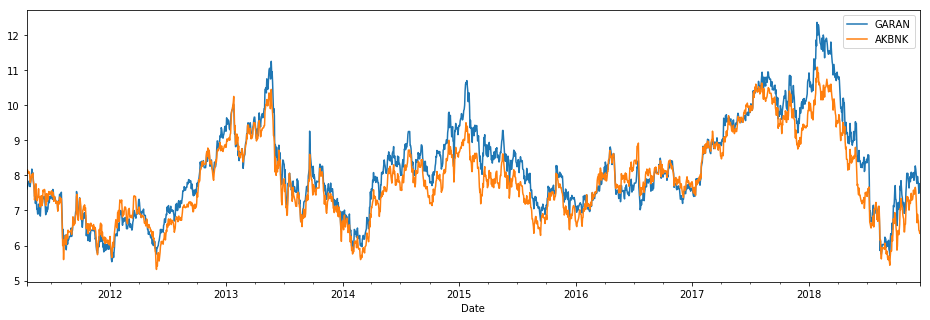

In [4]:
df.plot(figsize=(16,5))
plt.show()

By only visualizing our data, we can make some inference that our stocks would make pair trade; most of the time they follow each other and it offers some statistical arbitrage bevause of the divergence in some time points

### 1-(a) Compute daily log returns for your calibration periods. 
Compute and report the correlation between returns.Does the pair seem to be moving together? Do the correlations
change over time as you observe it across 3 cycles? Is correlation a good measure to
capture comovements?

In [5]:
df["LogGaran"] = np.log(df["GARAN"] / df["GARAN"].shift(1))
df["LogAk"] = np.log(df["AKBNK"] / df["AKBNK"].shift(1))

Visualization of __Daily Logarithmic Returns__

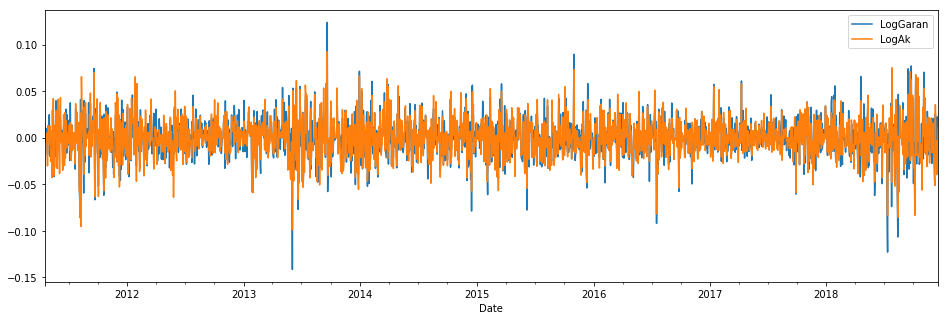

In [6]:
df[['LogGaran', 'LogAk']].dropna().plot(figsize=(16,5))
plt.show()

In [7]:
df = df.dropna()

In [8]:
print("Correlation coefficient of two returns are calculated as, \n"\
      ,df[["LogGaran","LogAk"]].corr(method='pearson', min_periods=1))

Correlation coefficient of two returns are calculated as, 
           LogGaran    LogAk
LogGaran   1.00000  0.87461
LogAk      0.87461  1.00000


In [9]:
print('---'*15)
print("Correlation for first 1000 days \n"\
      , df.loc[:'2015-02-12',["LogGaran", "LogAk"]].corr(method='pearson', min_periods=1))
print('---'*15)
print("Correlation for first 1500 days \n"\
      , df.loc[:'2017-01-17',["LogGaran", "LogAk"]].corr(method='pearson', min_periods=1))
print('---'*15)

---------------------------------------------
Correlation for first 1000 days 
           LogGaran     LogAk
LogGaran  1.000000  0.866407
LogAk     0.866407  1.000000
---------------------------------------------
Correlation for first 1500 days 
           LogGaran     LogAk
LogGaran  1.000000  0.874809
LogAk     0.874809  1.000000
---------------------------------------------


Scatter Matrix of Logarithmic Returns


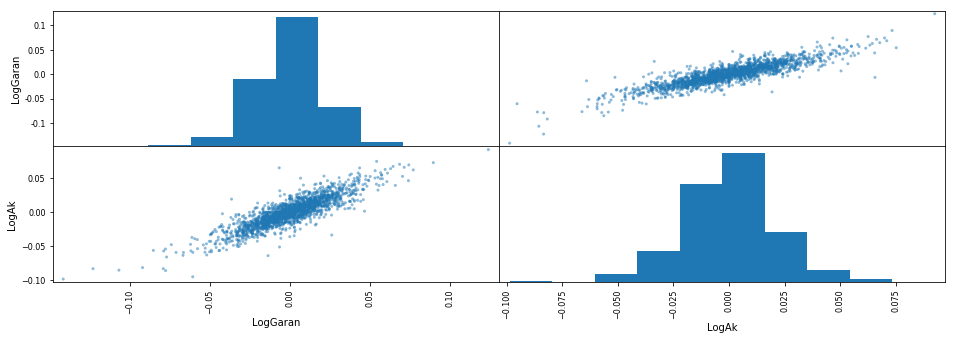

In [10]:
print("\033[91m"+"Scatter Matrix of Logarithmic Returns"+'\033[0m')
pd.plotting.scatter_matrix(df[["LogGaran", "LogAk"]].dropna(), figsize=(16, 5))
plt.show()

In [11]:
moving_correlation500 = df['LogGaran'].dropna().rolling(500).corr(df['LogAk'].dropna())
moving_correlation250 = df['LogGaran'].dropna().rolling(250).corr(df['LogAk'].dropna())

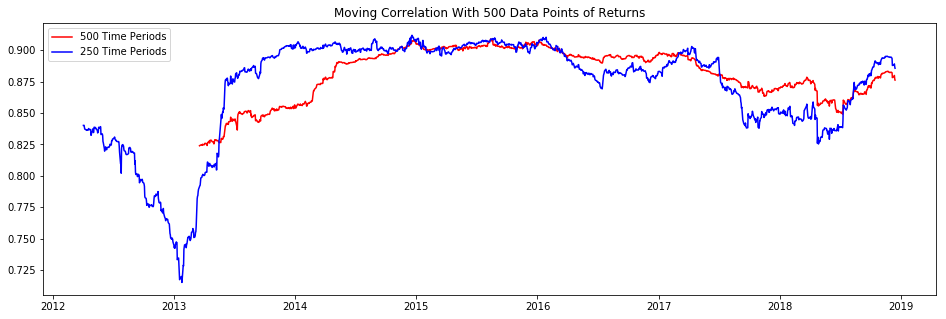

In [12]:
plt.figure(figsize=(16,5))
plt.title("Moving Correlation With 500 Data Points of Returns")
plt.plot(moving_correlation500, 'r', label='500 Time Periods')
plt.plot(moving_correlation250, 'b', label='250 Time Periods')
plt.legend(loc='upper left')
plt.show()

---
Thanks to arguments above, it is possible to say that correlation is a good measurement of capturing the comovements of stocks. Finally, as we inspect the moving correlation series, it is possible to address the times of seperation of the comovements.

---

### 1-b) Compute log prices for your calibration periods. 
Compute and report the correlation
between log prices. Does the pair seem to be moving together now? Graph the
log prices for the calibration period? Does this pair seem to be a good candidate for pairs
trading?

In [13]:
df["LogPG"] = np.log(df.GARAN) #Logarithm of the price for Garanti
df["LogPA"] = np.log(df.AKBNK) #Logarithm of the price for Akbank

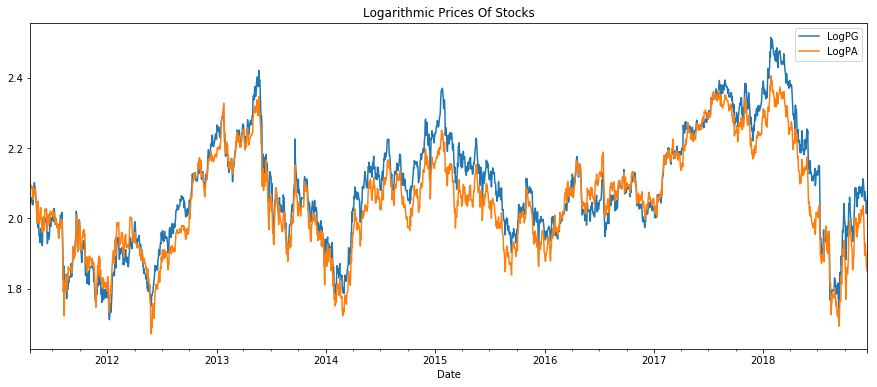

In [14]:
df[["LogPG", "LogPA"]].plot(figsize=(15,6))
plt.title("Logarithmic Prices Of Stocks")
plt.show()

As we saw that prices were moving together, now can comment that logarithms of the prices also move together. We also can conclude that those two stocks would make a good pair for statistical arbitrage.

In [15]:
print("Correlation coefficient of two "+"\033[1m"+"Logarithmic Prices"+"\033[0m"+" are calculated as, \n"\
      ,df[["LogPG","LogPA"]].corr(method='pearson', min_periods=1))

Correlation coefficient of two Logarithmic Prices are calculated as, 
           LogPG     LogPA
LogPG  1.000000  0.955998
LogPA  0.955998  1.000000


## 2) Cointegration - Engle-Granger Method
The idea of _moving together_ can be defined in many ways, but most technically correct
way is through _cointegration_. The variable of interest could also be price spreads, return
spreads, price ratios, correlations etc. We choose to use log prices because it offers us a
chance to capture spreads in log returns.

Econometrics literature offers various methods for testing cointegration. We choose to
use popular Engle-Granger two step method. A pair of assets is said to be cointegrated
(of order 1) if a linear combination of the two variables (spread) is stationary. This
method offers a very straight-forward method for testing.

### 2-a) 
We have computed log prices above. Let's Run the following
OLS regression on these variables for that time period. 
$$P_t^{GARAN} = \alpha + \beta P_t^{AKBNK} + \epsilon_t$$

In [16]:
from scipy import stats # Another package for linear regression

In [17]:
X = df['LogAk']
Y = df['LogGaran']
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

In [18]:
print("slope: %f    intercept: %f" % (slope, intercept))

slope: 0.898700    intercept: 0.000116


In [19]:
print("R-squared is calculated as: %f" % r_value**2)

R-squared is calculated as: 0.764943


In [20]:
print("Standart Error is calculated as: %f" % std_err)

Standart Error is calculated as: 0.011148


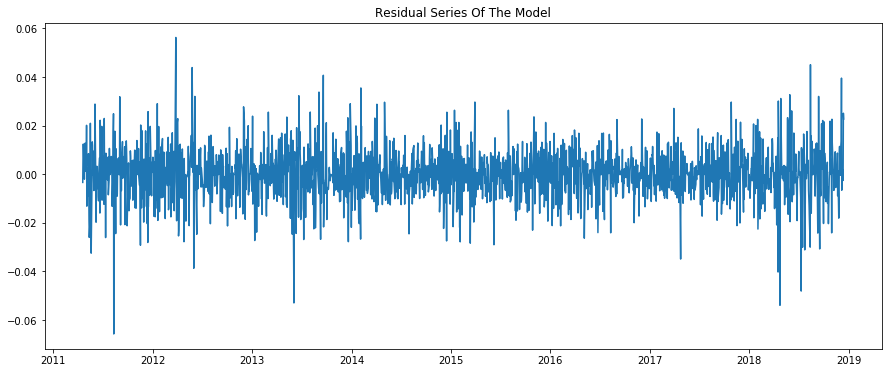

In [21]:
# This calculates the predicted value for each observed value
obs_values = df.LogGaran
pred_values = slope * df.LogAk + intercept

# This prints the residual for each pair of observations
Residual = obs_values - pred_values
plt.figure(figsize=(15,6))
plt.plot(Residual)
plt.title("Residual Series Of The Model")
plt.show()

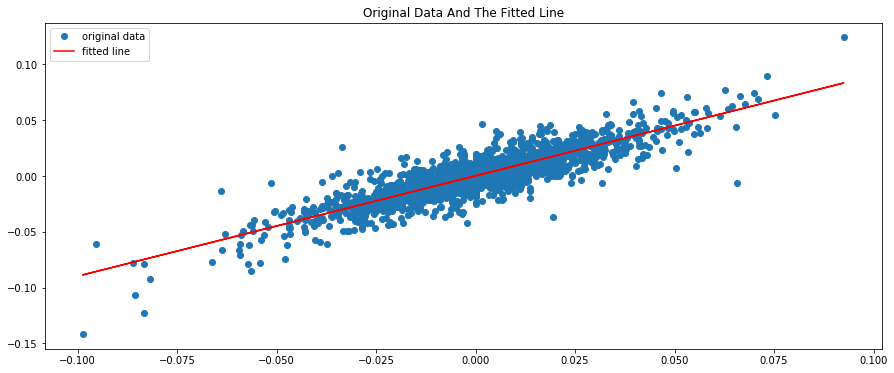

In [22]:
plt.figure(figsize=(15,6))
plt.plot(X, Y, 'o', label='original data')
plt.plot(X, intercept + slope*X, 'r', label='fitted line')
plt.title("Original Data And The Fitted Line")
plt.legend()
plt.show()

### 2-c) Graph the standardized residuals
Do they actually
display mean reverting property based on simple visual inspection of the graph?

In [23]:
StandartRes = Residual / Residual.std()

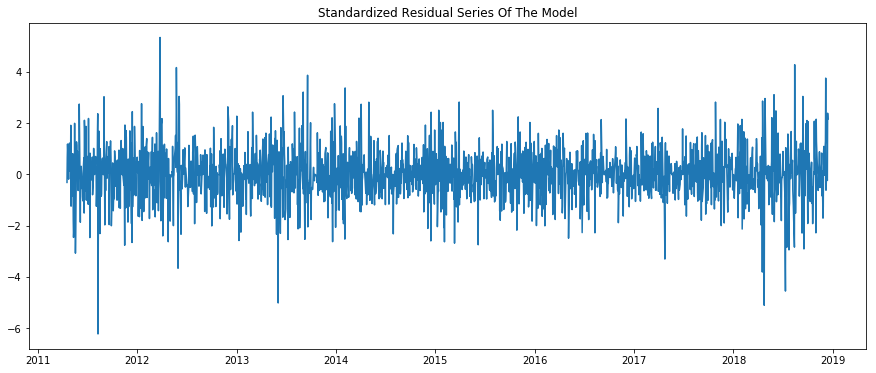

In [24]:
plt.figure(figsize=(15,6))
plt.plot(StandartRes)
plt.title("Standardized Residual Series Of The Model")
plt.show()

By simply inspecting the visual outputs one can conclude that standardized residuals of the logarithmic returns model is mean reverting.

## 3) Strategy

It should be noted that including the intercept term in the definition of cointegration
should be considered carefully. We allowed for an intercept term to keep a general approach,
however, this intercept term will not be traded once the pair strategy is set-up.
In reality, we only take positions in the stocks at the appropriate ratio.

### 3-a) 
Considering the results of the regression above and keeping in mind that $P$ are
log prices, let's compute the ratio $H = \dfrac{\beta P_t^{AKBNK}}{P_t^{GARAN$}}$ at the last day of your calibration period.
Note that $\beta$ represents the number of shares of AKBNK stock bought or sold for each
share of GARAN. Thus, $H$ represents the lira amount of AKBNK shares that shall be
bought or sold for every 1 lira in GARAN.

In [25]:
H = (df.LogAk * slope)/df.LogGaran

In [26]:
print("H value calculated for the day 500'th is {} and for the 1000'th day is {}".format(H[500], H[1000]))

H value calculated for the day 500'th is 1.3102842725570807 and for the 1000'th day is 0.7352143121267218


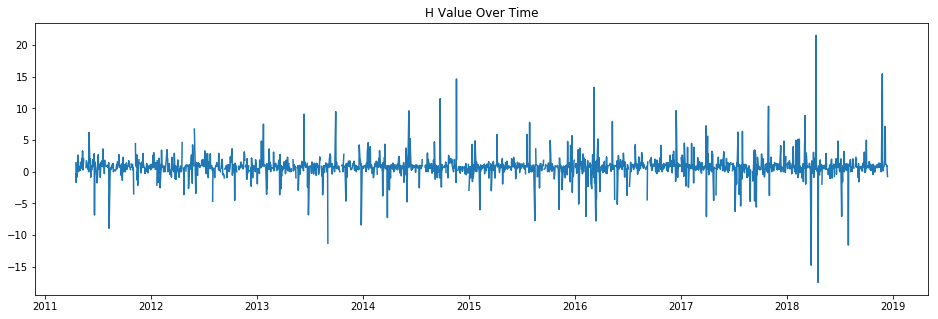

In [27]:
plt.figure(figsize=(16,5))
plt.plot(H)
plt.title("H Value Over Time")
plt.show()

### 3-b)
For each day t in the backtest period, let's compute the spread below using $\alpha$ and $\beta$
values found in calibration period.
$$Spread_t = P_t^{GARAN} - \beta P_t^{AKBNK} - \alpha$$

In [28]:
Spread = df.LogGaran - (slope*df.LogAk - intercept)

### 3-c)
Let's standardize the spreads by dividing them by the standard deviation of residuals
we found in calibration period. The standard deviation $\sigma$ would be the square root of
Mean Squared Errors (MSE) our regression results.

In [29]:
Standard_spread = Spread / Residual.std()

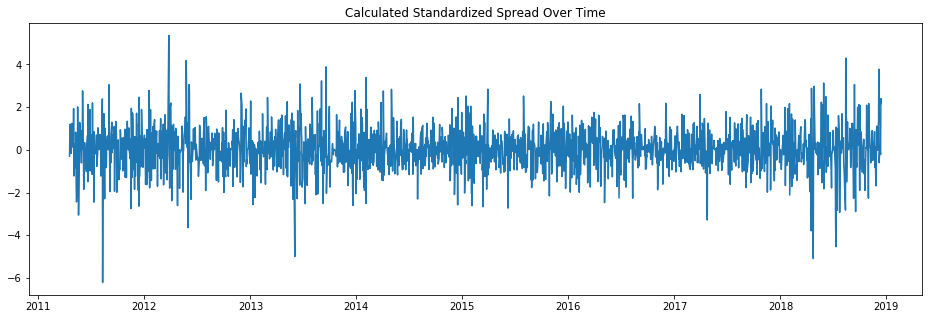

In [30]:
plt.figure(figsize=(16,5))
plt.plot(Standard_spread)
plt.title("Calculated Standardized Spread Over Time")
plt.show()

## 4) Backtesting

__(a)__ Now on to testing our trading strategy. A standard strategy would be to open
a trade when spread exceeds $\pm{2\sigma}$ (simply 2 for standardized spreads computed
in part c above) and close the position when the spread reverts back to zero with stop
loss set up at $\pm{4\sigma}$ (simply 4 for standardized spreads). This is not guaranteed to work
for every pair. Based on inspection of calibration data, such as the graph we draw above, tinker with similar strategies to find one that has the potential to
generate future profits.

__(b)__ Go through our backtesting period standardized spreads to mark our trade
open and close days, which can be  accomplished by using a simple if () function.

__(c)__ Let's compute the pairs trade daily returns through our trades considering you hold H liras in AKBNK for each 1 lira in GARAN shares. Note that if $Spread_t \geq 2\sigma$ we short 1 lira of GARAN and long _H_ liras in AKBNK and vice versa. 

__(d)__ Lastly, we should compute the return of a hypothetical lira invested in each stock and the
pairs trade across our backtest periods by repeating the process over the three rolling
windows. Graph the performance of that unit investment for these three investments,
two stocks and the pair spread. Compute the total return, average return, volatility and
Sharpe ratio for each of these three investments. Compare the performance of your pairs
trade with the individual shares.

In [31]:
df["Spread"] = Standard_spread

In [32]:
df.head()

,GARAN,AKBNK,LogGaran,LogAk,LogPG,LogPA,Spread
Date,,,,,,,
2011-04-19,7.68,8.16,0.007843,0.012331,2.038620,2.099244,-0.296030
2011-04-20,7.70,8.12,0.002601,-0.004914,2.041220,2.094330,0.676379
2011-04-21,7.78,8.10,0.010336,-0.002466,2.051556,2.091864,1.201232
2011-04-22,7.82,8.06,0.005128,-0.004951,2.056685,2.086914,0.919139
2011-04-25,7.84,8.10,0.002554,0.004951,2.059239,2.091864,-0.168630


In [33]:
df = df.reset_index()

In [34]:
long = [None]*2000
short = [None]*2000
closed = [None]*2000
for i in range(1, len(df)):
    if df.loc[i, 'Spread'] > 2:
        short[i] = df.loc[i, 'GARAN']
        long[i] = df.loc[i, "AKBNK"]
        if  df.loc[i, 'Spread'] < 0.01:
            closed[i] = df.loc[i, "AKBNK"]
    if df.loc[i, 'Spread'] < -2:
        long[i] = df.loc[i, 'GARAN']
        short[i] = df.loc[i, "AKBNK"]
        if df.loc[i, 'Spread'] > -0.01:
            closed[i] = df.loc[i, "GARAN"]

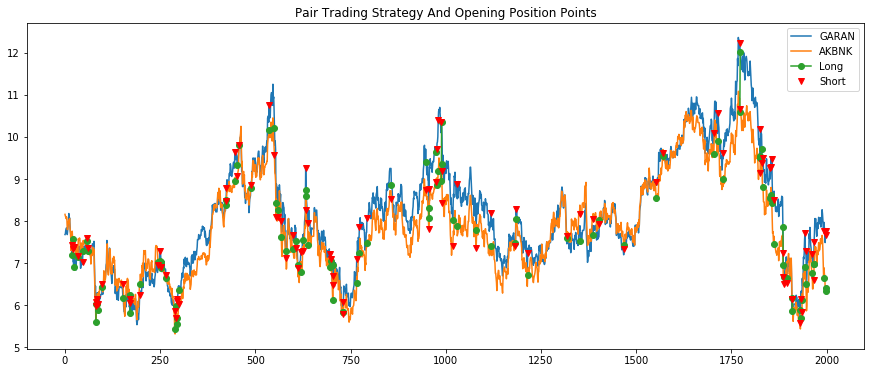

In [35]:
plt.figure(figsize=(15,6))
plt.title("Pair Trading Strategy And Opening Position Points")
plt.plot(df.GARAN)
plt.plot(df.AKBNK)
plt.plot(long, marker= 'o', label='Long')
plt.plot(short,'vr', label='Short')
#plt.plot(closed, '*', label='Closed')
plt.legend()
plt.show()

In [36]:
long = [None]*2000
short = [None]*2000
closed = [None]*2000
for i in range(1, len(df)):
    if df.loc[i, 'Spread'] > 2:
        short[i] = df.loc[i, 'GARAN']
        long[i] = df.loc[i, "AKBNK"]
        if  df.loc[i, 'Spread'] < 0.01:
            closed[i] = df.loc[i, "AKBNK"]
    if df.loc[i, 'Spread'] < -2:
        long[i] = df.loc[i, 'GARAN']
        short[i] = df.loc[i, "AKBNK"]
        if df.loc[i, 'Spread'] > -0.01:
            closed[i] = df.loc[i, "GARAN"]

In [37]:
Gar = [None]*1999
Ak = [None]*1999
for i in range(1, len(df)):
    if df.loc[i, 'Spread'] >2:
        Gar[i] = -1
        Ak[i] = 1
    if df.loc[i, 'Spread'] >0 and Gar[i-1] == -1:
        Gar[i] = -1
        Ak[i] = 1
    if df.loc[i, 'Spread'] <0 and Gar[i-1] == -1:
        Gar[i] = 0
        Ak[i] = 0
    if df.loc[i, 'Spread'] < -2:
        Gar[i] = 1
        Ak[i] = -1
    if df.loc[i, 'Spread'] <0 and Gar[i-1] == 1:
        Gar[i] = 1
        Ak[i] = -1
    if df.loc[i, 'Spread'] >0 and Gar[i-1] == 1:
        Gar[i] = 0
        Ak[i] = 0

In [38]:
for i in range(1500,1999):
    if Gar[i] ==1:
        print("Long GARAN, short AKBNK at {}'th day".format(i))
    elif Gar[i] == -1:
        print("Long AKBNK, short GARAN at {}'th day".format(i))
    elif Gar[i] == 0:
        print("Close the deal at {}'th day".format(i))

Long AKBNK, short GARAN at 1552'th day
Close the deal at 1553'th day
Long GARAN, short AKBNK at 1569'th day
Close the deal at 1570'th day
Long AKBNK, short GARAN at 1703'th day
Close the deal at 1704'th day
Long AKBNK, short GARAN at 1715'th day
Long AKBNK, short GARAN at 1716'th day
Close the deal at 1717'th day
Long AKBNK, short GARAN at 1727'th day
Long AKBNK, short GARAN at 1728'th day
Long AKBNK, short GARAN at 1729'th day
Long AKBNK, short GARAN at 1730'th day
Long AKBNK, short GARAN at 1731'th day
Long AKBNK, short GARAN at 1732'th day
Close the deal at 1733'th day
Long AKBNK, short GARAN at 1772'th day
Long GARAN, short AKBNK at 1773'th day
Long GARAN, short AKBNK at 1774'th day
Long GARAN, short AKBNK at 1775'th day
Close the deal at 1776'th day
Long GARAN, short AKBNK at 1825'th day
Close the deal at 1826'th day
Long GARAN, short AKBNK at 1830'th day
Long GARAN, short AKBNK at 1831'th day
Close the deal at 1832'th day
Long AKBNK, short GARAN at 1833'th day
Long AKBNK, short G

In [39]:
df["Ak İşlem"] = Ak
df["Gar İşlem"] = Gar

In [44]:
df['AR'] = (df.AKBNK - df.AKBNK.shift(1)) / df.AKBNK.shift(1)
df['GR'] = (df.GARAN - df.GARAN.shift(1)) / df.GARAN.shift(1)

In [61]:
transactionAK = [100]
for i in range(1,len(df)-1):
    if df.loc[i,"Ak İşlem"] == 1:
        transactionAK.append(transactionAK[-1]*df.loc[i+1,'AR'] + transactionAK[-1])
    if df.loc[i,"Ak İşlem"] == -1:
        transactionAK.append(transactionAK[-1]*df.loc[i+1,'AR']*-1 + transactionAK[-1])
    if df.loc[i,"Ak İşlem"] == 0:
        transactionAK.append(transactionAK[-1])

In [62]:
transactionGARAN = [100]
for i in range(1,len(df)-1):
    if df.loc[i,"Gar İşlem"] == 1:
        transactionGARAN.append(transactionGARAN[-1]*df.loc[i+1,'GR'] + transactionGARAN[-1])
    if df.loc[i,"Gar İşlem"] == -1:
        transactionGARAN.append(transactionGARAN[-1]*df.loc[i+1,'GR']*-1 + transactionGARAN[-1])
    if df.loc[i,"Gar İşlem"] == 0:
        transactionGARAN.append(transactionGARAN[-1])

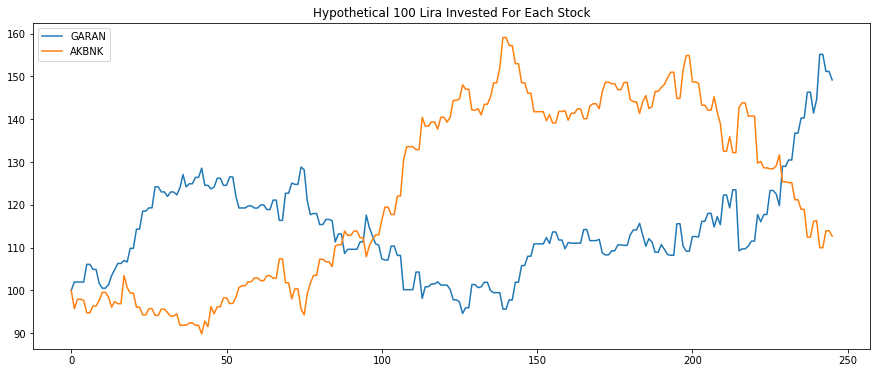

In [64]:
plt.figure(figsize=(15,6))
plt.title("Hypothetical 100 Lira Invested For Each Stock")
plt.plot(transactionGARAN, label="GARAN")
plt.plot(transactionAK, label="AKBNK")
plt.legend()
plt.show()

## Conclusion:
By allocating 100 Liras for each of the stock and trading long or short in case of the change of spread value we made 250 transactions (closing transaction are added) and by the end of the period we raised our 200 Liras to almost 260 Liras. 
Considering the long time period, this investment might not be a tempting strategy but one should pay attention to that; we implemented our strategy with only 1 pair.